In [1]:
import os
import re
import requests
import json
import time

import pandas as pd

import matplotlib.pyplot as plt
from matplotlib import rc

from bs4 import BeautifulSoup

import nltk
from nltk import Text
from nltk.tag import pos_tag
from nltk.stem import PorterStemmer
from nltk.tokenize import sent_tokenize, word_tokenize, RegexpTokenizer

from wordcloud import WordCloud

from konlpy.tag import Hannanum, Kkma, Komoran, Twitter, Okt
from konlpy.corpus import kolaw
from keras_preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Embedding, SimpleRNN, RNN, Dense

In [2]:
pd.set_option('display.max_rows', None)  # 최대 행 수 제한 해제
pd.set_option('display.max_columns', None)  # 최대 열 수 제한 해제
pd.set_option('display.width', None)  # 자동 너비 조정 해제
pd.set_option('display.max_colwidth', None)  # 최대 컬럼 너비 해제

In [3]:
os.environ.get('JAVA_HOME')

'/Library/Java/JavaVirtualMachines/jdk-17.jdk/Contents/Home'

In [4]:
%ls

?DNN.ipynb
KOSIS/
csv_file/
data_go_kr/
jpype1-1.5.1-cp312-cp312-macosx_10_9_universal2.whl
model/
openAPI_자연어처리_RNN.ipynb


In [5]:
! pip install jpype1-1.5.1-cp312-cp312-macosx_10_9_universal2.whl

Processing ./jpype1-1.5.1-cp312-cp312-macosx_10_9_universal2.whl
jpype1 is already installed with the same version as the provided wheel. Use --force-reinstall to force an installation of the wheel.


In [6]:
nltk.download('punkt_tab')
nltk.download('averaged_perceptron_tagger_eng')
nltk.download('wordnet')

[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/imsehyeon/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /Users/imsehyeon/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/imsehyeon/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

# openAPI를 이용하여 뉴스 기사 검색

In [7]:
# API 호출을 위한 설정
client_id = 'RgKYwTbMqCx5s9yGYqsT'
client_secret = '1INoZ2YkcD'
query = '흡연구역'
items_list = []

# 네이버 뉴스 API 호출
url = f'https://openapi.naver.com/v1/search/news.json?query={query}&display=30'
headers = {'X-Naver-Client-Id' : client_id, 'X-Naver-Client-Secret' : client_secret}
response = requests.get(url, headers=headers)

# 뉴스 아이템 리스트 추출
items = json.loads(response.text)['items']

# 각 뉴스의 제목, 링크, 설명, 본문을 추출
for item in items:
    title = item['title'].replace('<b>', '').replace('</b>', '').replace('&quot;', '')
    link = item['link']
    description = item['description'].replace('<b>', '').replace('</b>', '').replace('&quot;', '')
    
    # 본문 크롤링
    try:
        # 기사 페이지에 접속
        article_response = requests.get(link)
        article_soup = BeautifulSoup(article_response.text, 'html.parser')

        # 뉴스 본문 찾기 (일반적인 뉴스 페이지에서는 본문이 <div class="article_body">로 감싸져 있음)
        # 이 부분은 네이버 뉴스 페이지 구조에 따라 다를 수 있음
        article_content = article_soup.find('div', {'id': 'newsct_article'})
        if article_content:
            article_text = article_content.get_text().strip().replace('\n\n\n\n', '')
        else:
            article_text = "본문을 찾을 수 없습니다."
        
    except Exception as e:
        print(f"Error fetching article from {link}: {e}")
        article_text = "본문을 가져오는 데 실패했습니다."

    # 데이터 추가
    items_list.append([title, link, description, article_text])

# DataFrame으로 변환하여 출력
df = pd.DataFrame(items_list, columns=['title', 'link', 'description', 'content'])

In [8]:
df

,title,link,description,content
0,에어커튼까지 설치해 흡연?...서초구 ‘개방형 구역’ 논란,https://n.news.naver.com/mnews/article/024/0000094465?sid=102,"전국 최초로 ‘개방형 흡연시설’이 설치됐다. 개방형 흡연시설은 벽 없이 열린 형태로, 에어커튼과 제연 정화장치가 설치된 시설이다. 서울시 서초구는 강남역 이면도로(서초대로 78길) 일대에 ‘서초 개방형 제연...","서초 개방형 제연 흡연시설. (출처=연합뉴스)전국 최초로 ‘개방형 흡연시설’이 설치됐다. 개방형 흡연시설은 벽 없이 열린 형태로, 에어커튼과 제연 정화장치가 설치된 시설이다.서울시 서초구는 강남역 이면도로(서초대로 78길) 일대에 ‘서초 개방형 제연 흡연시설’을 운영한다고 20일 밝혔다. 서초구는 다음 달 강남역 인근 2곳에 더 설치할 예정이라고 전했다.개방형 흡연시설이 설치된 강남역 이면도로는 음식점, 업무시설 등 상업시설이 밀집해 유동 인구가 많다. 따라서 무분별한 흡연이 이어지고 있었다. 보행자의 간접흡연 피해를 최소화하는 게 개방형 흡연시설 설치의 취지다.이 시설은 가로 2.4ｍ, 세로 7.2ｍ, 높이 3.4ｍ의 규모다. 기둥 3개로 떠받치는 구조로 최대 20명이 동시에 이용할 수 있다. 이 시설은 벽면 4면과 지붕을 포함한 총 5면 중 50% 이상을 개방형으로 할 것을 권고하는 세계보건기구 담배규제기본협약에 따라 만들어졌다.이 시설의 3면에 에어커튼이 설치됐다. 지붕은 회오리 특허 공법의 제연 정화장치 4대가 탑재됐다. 또 3개 기둥 각각에 자동 소화 기능을 갖춘 재떨이 12개가 설치됐다.전성수 서초구청장은 “이번 시설은 간접흡연 최소화와 흡연자·비흡연자 간 상생을 목표로 수년간 고민 끝에 만들어진 모델”이라며 “앞으로도 주민들이 체감할 수 있는 간접흡연 예방과 금연 정책을 추진해 나가겠다”고 말했다. 그러나 일각에선 흡연을 자제하자는 세계적인 추세를 감안할때, 시민 세금을 들여가며 이렇게까지 흡연의 편의를 도모해줘야 하냐는 지적이 일고 있다."
1,"아기 아빠 슬리피, 건강 안 챙겨 무릎까지 꿇었다 (+이유)",https://www.wikitree.co.kr/articles/1019853,"미국 예일대 연구팀은 15년 동안 금연구역으로 지정된 영화관 내에 깨끗한 공기를 공급한 후 관객 70~220명을 입장시켰다. 관객에는 흡연자와 비흡연자가 모두 포함됐다. 이후 영화관 공기 질을 확인한 결과, 벤젠...",본문을 찾을 수 없습니다.
2,[노원구] 담배 끊으면 지원금 쏟아져요,https://n.news.naver.com/mnews/article/020/0003611204?sid=102,금연 구역 흡연 단속 과태료를 재원으로 활용해 금연에 성공할 경우 3년간 최대 60만 원의 현금을 지급한다. 구의 금연 지원 사업에서 눈여겨 볼 것은 체계적인 관리다. 전문 상담사가 참여자들과의 일대일 상담을 통해...,금연클리닉 사업 눈길전문 상담사가 금연 지원 사업 참여자와 상담하고 있다. 노원구 제공노원구(구청장 오승록)가 구민들의 건강한 삶을 지원하기 위해 금연성공지원금 지급을 포함해 다양한 금연사업을 실시해 눈길을 끈다. 구는 2014년부터 전국 최초로 금연 성공자들에게 포상금을 지급해왔다. 금연 구역 흡연 단속 과태료를 재원으로 활용해 금연에 성공할 경우 3년간 최대 60만 원의 현금을 지급한다.구의 금연 지원 사업에서 눈여겨 볼 것은 체계적인 관리다. 전문 상담사가 참여자들과의 일대일 상담을 통해 흡연 형태와 습관을 파악한 후 흡연 충동을 억제할 수 있는 운동 등 맞춤형 처방을 준다. 초기 상담은 니코틴 의존도 검사를 포함해 40분 이상 진행되며 2회차부터는 대면 또는 전화 상담을 통해 참여자들의 금연을 돕는다. 이외에도 구는 △찾아가는 이동금연클리닉 △청소년 흡연제로 프로그램 △금연 캠페인 등 다양한 사업을 추진한다. 지난해 노원구 금연클리닉을 찾아 등록 관리한 대상자는 2638명이며 성공지원금은 지급액은 1억2800만 원에 달한다.오 구청장은 “앞으로도 많은 구민들의 금연 성공을 적극 지원하겠다”고 말했다.
3,"울산 울주군, 뉴시티에일린의뜰1차 아파트 금연 아파트 지정",https://www.pinpointnews.co.kr/news/articleView.html?idxno=314978,"울주군은 금연아파트 지정 후 3개월간 계도와 홍보를 하고, 오는 4월 20일부터 지정 구역에서 흡연행위 적발 시 5만원의 과태료를 부과한다. 울주군보건소는 지정된 금연구역 홍보·관리를 위해 현판과 현수막을 지원하며...",본문을 찾을 수 없습니다.
4,"서초구, 전국 첫 '벽 없는 제연·흡연실' 설치 [메트로]",https://n.news.naver.com/mnews/article/015/0005084696?sid=102,"구는 새로운 흡연 부스 설치 외에도 지난해 3월 어린이공원 경계 10m이내를 금연 구역으로 지정, 흡연 위반확인서(종이)에 금연교육 QR코드 삽입, 담배 비규범화 교육 '청소년 건강해영' 등의 정책을 시행하고 있다.","강남역 일대 1곳 운영 시작올해 5곳까지 확대 추진사진=서초구서울 서초구가 전국에서 처음으로 벽 없이 열린 형태의 제연·흡연시설 가동을 시작했다. 시는 간접흡연 예방을 목표로 올해 해당 시설을 5곳까지 확대하도록 추진할 계획이다.20일 서울 서초구(구청장 전성수)는 강남역 이면도로(서초대로 78길 일대)에 전국 최초로 에어커튼을 장착한 '서초 개방형 제연 흡연시설'을 설치하고 운영을 시작했다고 밝혔다. 구는 내달 이 일대 2곳을 추가 설치해 강남역 이면도로에만 총 3곳을 운영할 예정이다.구 관계자는 ""강남역 이면도로 일대는 유동 인구가 많고, 음식점, 업무시설 등 상업시설이 밀집해 있어 무분별한 흡연이 이뤄져 왔다""며 ""간접흡연을 최소화할 수 있는 효과적인 대책이 필요하다고 판단해 연구용역을 거쳐 구상한 새 흡연 부스를 올해 최대 5곳까지 확대할 계획""이라고 설명했다.해당 시설은 가로 2.4m, 세로 7.2m, 높이 3.4m의 규모다. 은백색의 바탕에 기둥 3개로 떠받치는 구조다. 3개 기둥마다 자동 소화 기능을 갖춘 재떨이 12개도가 설치됐다. 최대 20명이 동시에 이용할 수 있다.사진=서초구담배 냄새로 폐쇄된 흡연실을 싫어하는 흡연자와 담배 연기로 불편을 겪는 비흡연자를 모두 고려해 설계됐다.우선 3면에 에어커튼을 설치해 외부 담배 연기 차단 효과를 강화했다. 세계보건기구 담배규제기본협약에 따라 실외 흡연시설 설치시 벽면 4면과 지붕을 포함한 총 5면 중 절반 이상을 개방형으로 만들도록 권고한 부분을 반영했다.또 지붕에 제연 정화장치 4대를 탑재해 담배연기를 정화한 후 배출하도록 만들어 냄새가 거의 나지 않도록 했다. 동작인식 센서가 있어 흡연자가 떠난 후 10분 뒤에는 자동으로 작동이 멈춘다.전성수 서초구청장은 ""서초 제연 개방형 흡연시설은 간접흡연 최소화와 흡연자와 비흡연자 간 상생을 목표로 수년간 고민 끝에 만들어진 모델""이라며 ""앞으로도 주민들이 체감할 수 있는 간접흡연 예방과 금연 정책을 추진해 나갈 것""이라고 했다.구는 새로운 흡연 부스 설치 외에도 지난해 3월 어린이공원 경계 10m이내를 금연 구역으로 지정, 흡연 위반확인서(종이)에 금연교육 QR코드 삽입, 담배 비규범화 교육 '청소년 건강해영' 등의 정책을 시행하고 있다."
5,"서초구, 전국 최초 개방형 제연 흡연시설 본격 운영",https://www.newspim.com/news/view/20250120001101,흡연시설 인근에는 실외 금연·흡연구역을 알려주는 '서초 금연(흡연)구역 QR안내판'과 흡연시설 유도 자동 음성시스템도 설치했다. 이를 통해 시설 내 흡연을 유도하고 담배꽁초 무단투기를 줄인다는 계획이다. 그간...,본문을 찾을 수 없습니다.
6,"청주청원경찰서, 사직1동 재개발구역 일대 합동점검",http://www.cctimes.kr/news/articleView.html?idxno=828393,▲ 목성수 청주청원경찰서장이 20일 오후 청주시 서원구 사직1동 재개발구역 내 모텔촌 일대를 점검하고... 합동점검단은 △빈집 밀집 지역 일대 담장 붕괴 등 위험요소

In [9]:
df['content'] = df['content'].replace('본문을 찾을 수 없습니다.', '-')
df

,title,link,description,content
0,에어커튼까지 설치해 흡연?...서초구 ‘개방형 구역’ 논란,https://n.news.naver.com/mnews/article/024/0000094465?sid=102,"전국 최초로 ‘개방형 흡연시설’이 설치됐다. 개방형 흡연시설은 벽 없이 열린 형태로, 에어커튼과 제연 정화장치가 설치된 시설이다. 서울시 서초구는 강남역 이면도로(서초대로 78길) 일대에 ‘서초 개방형 제연...","서초 개방형 제연 흡연시설. (출처=연합뉴스)전국 최초로 ‘개방형 흡연시설’이 설치됐다. 개방형 흡연시설은 벽 없이 열린 형태로, 에어커튼과 제연 정화장치가 설치된 시설이다.서울시 서초구는 강남역 이면도로(서초대로 78길) 일대에 ‘서초 개방형 제연 흡연시설’을 운영한다고 20일 밝혔다. 서초구는 다음 달 강남역 인근 2곳에 더 설치할 예정이라고 전했다.개방형 흡연시설이 설치된 강남역 이면도로는 음식점, 업무시설 등 상업시설이 밀집해 유동 인구가 많다. 따라서 무분별한 흡연이 이어지고 있었다. 보행자의 간접흡연 피해를 최소화하는 게 개방형 흡연시설 설치의 취지다.이 시설은 가로 2.4ｍ, 세로 7.2ｍ, 높이 3.4ｍ의 규모다. 기둥 3개로 떠받치는 구조로 최대 20명이 동시에 이용할 수 있다. 이 시설은 벽면 4면과 지붕을 포함한 총 5면 중 50% 이상을 개방형으로 할 것을 권고하는 세계보건기구 담배규제기본협약에 따라 만들어졌다.이 시설의 3면에 에어커튼이 설치됐다. 지붕은 회오리 특허 공법의 제연 정화장치 4대가 탑재됐다. 또 3개 기둥 각각에 자동 소화 기능을 갖춘 재떨이 12개가 설치됐다.전성수 서초구청장은 “이번 시설은 간접흡연 최소화와 흡연자·비흡연자 간 상생을 목표로 수년간 고민 끝에 만들어진 모델”이라며 “앞으로도 주민들이 체감할 수 있는 간접흡연 예방과 금연 정책을 추진해 나가겠다”고 말했다. 그러나 일각에선 흡연을 자제하자는 세계적인 추세를 감안할때, 시민 세금을 들여가며 이렇게까지 흡연의 편의를 도모해줘야 하냐는 지적이 일고 있다."
1,"아기 아빠 슬리피, 건강 안 챙겨 무릎까지 꿇었다 (+이유)",https://www.wikitree.co.kr/articles/1019853,"미국 예일대 연구팀은 15년 동안 금연구역으로 지정된 영화관 내에 깨끗한 공기를 공급한 후 관객 70~220명을 입장시켰다. 관객에는 흡연자와 비흡연자가 모두 포함됐다. 이후 영화관 공기 질을 확인한 결과, 벤젠...",-
2,[노원구] 담배 끊으면 지원금 쏟아져요,https://n.news.naver.com/mnews/article/020/0003611204?sid=102,금연 구역 흡연 단속 과태료를 재원으로 활용해 금연에 성공할 경우 3년간 최대 60만 원의 현금을 지급한다. 구의 금연 지원 사업에서 눈여겨 볼 것은 체계적인 관리다. 전문 상담사가 참여자들과의 일대일 상담을 통해...,금연클리닉 사업 눈길전문 상담사가 금연 지원 사업 참여자와 상담하고 있다. 노원구 제공노원구(구청장 오승록)가 구민들의 건강한 삶을 지원하기 위해 금연성공지원금 지급을 포함해 다양한 금연사업을 실시해 눈길을 끈다. 구는 2014년부터 전국 최초로 금연 성공자들에게 포상금을 지급해왔다. 금연 구역 흡연 단속 과태료를 재원으로 활용해 금연에 성공할 경우 3년간 최대 60만 원의 현금을 지급한다.구의 금연 지원 사업에서 눈여겨 볼 것은 체계적인 관리다. 전문 상담사가 참여자들과의 일대일 상담을 통해 흡연 형태와 습관을 파악한 후 흡연 충동을 억제할 수 있는 운동 등 맞춤형 처방을 준다. 초기 상담은 니코틴 의존도 검사를 포함해 40분 이상 진행되며 2회차부터는 대면 또는 전화 상담을 통해 참여자들의 금연을 돕는다. 이외에도 구는 △찾아가는 이동금연클리닉 △청소년 흡연제로 프로그램 △금연 캠페인 등 다양한 사업을 추진한다. 지난해 노원구 금연클리닉을 찾아 등록 관리한 대상자는 2638명이며 성공지원금은 지급액은 1억2800만 원에 달한다.오 구청장은 “앞으로도 많은 구민들의 금연 성공을 적극 지원하겠다”고 말했다.
3,"울산 울주군, 뉴시티에일린의뜰1차 아파트 금연 아파트 지정",https://www.pinpointnews.co.kr/news/articleView.html?idxno=314978,"울주군은 금연아파트 지정 후 3개월간 계도와 홍보를 하고, 오는 4월 20일부터 지정 구역에서 흡연행위 적발 시 5만원의 과태료를 부과한다. 울주군보건소는 지정된 금연구역 홍보·관리를 위해 현판과 현수막을 지원하며...",-
4,"서초구, 전국 첫 '벽 없는 제연·흡연실' 설치 [메트로]",https://n.news.naver.com/mnews/article/015/0005084696?sid=102,"구는 새로운 흡연 부스 설치 외에도 지난해 3월 어린이공원 경계 10m이내를 금연 구역으로 지정, 흡연 위반확인서(종이)에 금연교육 QR코드 삽입, 담배 비규범화 교육 '청소년 건강해영' 등의 정책을 시행하고 있다.","강남역 일대 1곳 운영 시작올해 5곳까지 확대 추진사진=서초구서울 서초구가 전국에서 처음으로 벽 없이 열린 형태의 제연·흡연시설 가동을 시작했다. 시는 간접흡연 예방을 목표로 올해 해당 시설을 5곳까지 확대하도록 추진할 계획이다.20일 서울 서초구(구청장 전성수)는 강남역 이면도로(서초대로 78길 일대)에 전국 최초로 에어커튼을 장착한 '서초 개방형 제연 흡연시설'을 설치하고 운영을 시작했다고 밝혔다. 구는 내달 이 일대 2곳을 추가 설치해 강남역 이면도로에만 총 3곳을 운영할 예정이다.구 관계자는 ""강남역 이면도로 일대는 유동 인구가 많고, 음식점, 업무시설 등 상업시설이 밀집해 있어 무분별한 흡연이 이뤄져 왔다""며 ""간접흡연을 최소화할 수 있는 효과적인 대책이 필요하다고 판단해 연구용역을 거쳐 구상한 새 흡연 부스를 올해 최대 5곳까지 확대할 계획""이라고 설명했다.해당 시설은 가로 2.4m, 세로 7.2m, 높이 3.4m의 규모다. 은백색의 바탕에 기둥 3개로 떠받치는 구조다. 3개 기둥마다 자동 소화 기능을 갖춘 재떨이 12개도가 설치됐다. 최대 20명이 동시에 이용할 수 있다.사진=서초구담배 냄새로 폐쇄된 흡연실을 싫어하는 흡연자와 담배 연기로 불편을 겪는 비흡연자를 모두 고려해 설계됐다.우선 3면에 에어커튼을 설치해 외부 담배 연기 차단 효과를 강화했다. 세계보건기구 담배규제기본협약에 따라 실외 흡연시설 설치시 벽면 4면과 지붕을 포함한 총 5면 중 절반 이상을 개방형으로 만들도록 권고한 부분을 반영했다.또 지붕에 제연 정화장치 4대를 탑재해 담배연기를 정화한 후 배출하도록 만들어 냄새가 거의 나지 않도록 했다. 동작인식 센서가 있어 흡연자가 떠난 후 10분 뒤에는 자동으로 작동이 멈춘다.전성수 서초구청장은 ""서초 제연 개방형 흡연시설은 간접흡연 최소화와 흡연자와 비흡연자 간 상생을 목표로 수년간 고민 끝에 만들어진 모델""이라며 ""앞으로도 주민들이 체감할 수 있는 간접흡연 예방과 금연 정책을 추진해 나갈 것""이라고 했다.구는 새로운 흡연 부스 설치 외에도 지난해 3월 어린이공원 경계 10m이내를 금연 구역으로 지정, 흡연 위반확인서(종이)에 금연교육 QR코드 삽입, 담배 비규범화 교육 '청소년 건강해영' 등의 정책을 시행하고 있다."
5,"서초구, 전국 최초 개방형 제연 흡연시설 본격 운영",https://www.newspim.com/news/view/20250120001101,흡연시설 인근에는 실외 금연·흡연구역을 알려주는 '서초 금연(흡연)구역 QR안내판'과 흡연시설 유도 자동 음성시스템도 설치했다. 이를 통해 시설 내 흡연을 유도하고 담배꽁초 무단투기를 줄인다는 계획이다. 그간...,-
6,"청주청원경찰서, 사직1동 재개발구역 일대 합동점검",http://www.cctimes.kr/news/articleView.html?idxno=828393,▲ 목성수 청주청원경찰서장이 20일 오후 청주시 서원구 사직1동 재개발구역 내 모텔촌 일대를 점검하고... 합동점검단은 △빈집 밀집 지역 일대 담장 붕괴 등 위험요소 △노숙자 거주 여부 △음주·흡연·아지트 활용 등...,-
7,"청주청

In [10]:
df = df[df['content'] != '-']
df

,title,link,description,content
0,에어커튼까지 설치해 흡연?...서초구 ‘개방형 구역’ 논란,https://n.news.naver.com/mnews/article/024/0000094465?sid=102,"전국 최초로 ‘개방형 흡연시설’이 설치됐다. 개방형 흡연시설은 벽 없이 열린 형태로, 에어커튼과 제연 정화장치가 설치된 시설이다. 서울시 서초구는 강남역 이면도로(서초대로 78길) 일대에 ‘서초 개방형 제연...","서초 개방형 제연 흡연시설. (출처=연합뉴스)전국 최초로 ‘개방형 흡연시설’이 설치됐다. 개방형 흡연시설은 벽 없이 열린 형태로, 에어커튼과 제연 정화장치가 설치된 시설이다.서울시 서초구는 강남역 이면도로(서초대로 78길) 일대에 ‘서초 개방형 제연 흡연시설’을 운영한다고 20일 밝혔다. 서초구는 다음 달 강남역 인근 2곳에 더 설치할 예정이라고 전했다.개방형 흡연시설이 설치된 강남역 이면도로는 음식점, 업무시설 등 상업시설이 밀집해 유동 인구가 많다. 따라서 무분별한 흡연이 이어지고 있었다. 보행자의 간접흡연 피해를 최소화하는 게 개방형 흡연시설 설치의 취지다.이 시설은 가로 2.4ｍ, 세로 7.2ｍ, 높이 3.4ｍ의 규모다. 기둥 3개로 떠받치는 구조로 최대 20명이 동시에 이용할 수 있다. 이 시설은 벽면 4면과 지붕을 포함한 총 5면 중 50% 이상을 개방형으로 할 것을 권고하는 세계보건기구 담배규제기본협약에 따라 만들어졌다.이 시설의 3면에 에어커튼이 설치됐다. 지붕은 회오리 특허 공법의 제연 정화장치 4대가 탑재됐다. 또 3개 기둥 각각에 자동 소화 기능을 갖춘 재떨이 12개가 설치됐다.전성수 서초구청장은 “이번 시설은 간접흡연 최소화와 흡연자·비흡연자 간 상생을 목표로 수년간 고민 끝에 만들어진 모델”이라며 “앞으로도 주민들이 체감할 수 있는 간접흡연 예방과 금연 정책을 추진해 나가겠다”고 말했다. 그러나 일각에선 흡연을 자제하자는 세계적인 추세를 감안할때, 시민 세금을 들여가며 이렇게까지 흡연의 편의를 도모해줘야 하냐는 지적이 일고 있다."
2,[노원구] 담배 끊으면 지원금 쏟아져요,https://n.news.naver.com/mnews/article/020/0003611204?sid=102,금연 구역 흡연 단속 과태료를 재원으로 활용해 금연에 성공할 경우 3년간 최대 60만 원의 현금을 지급한다. 구의 금연 지원 사업에서 눈여겨 볼 것은 체계적인 관리다. 전문 상담사가 참여자들과의 일대일 상담을 통해...,금연클리닉 사업 눈길전문 상담사가 금연 지원 사업 참여자와 상담하고 있다. 노원구 제공노원구(구청장 오승록)가 구민들의 건강한 삶을 지원하기 위해 금연성공지원금 지급을 포함해 다양한 금연사업을 실시해 눈길을 끈다. 구는 2014년부터 전국 최초로 금연 성공자들에게 포상금을 지급해왔다. 금연 구역 흡연 단속 과태료를 재원으로 활용해 금연에 성공할 경우 3년간 최대 60만 원의 현금을 지급한다.구의 금연 지원 사업에서 눈여겨 볼 것은 체계적인 관리다. 전문 상담사가 참여자들과의 일대일 상담을 통해 흡연 형태와 습관을 파악한 후 흡연 충동을 억제할 수 있는 운동 등 맞춤형 처방을 준다. 초기 상담은 니코틴 의존도 검사를 포함해 40분 이상 진행되며 2회차부터는 대면 또는 전화 상담을 통해 참여자들의 금연을 돕는다. 이외에도 구는 △찾아가는 이동금연클리닉 △청소년 흡연제로 프로그램 △금연 캠페인 등 다양한 사업을 추진한다. 지난해 노원구 금연클리닉을 찾아 등록 관리한 대상자는 2638명이며 성공지원금은 지급액은 1억2800만 원에 달한다.오 구청장은 “앞으로도 많은 구민들의 금연 성공을 적극 지원하겠다”고 말했다.
4,"서초구, 전국 첫 '벽 없는 제연·흡연실' 설치 [메트로]",https://n.news.naver.com/mnews/article/015/0005084696?sid=102,"구는 새로운 흡연 부스 설치 외에도 지난해 3월 어린이공원 경계 10m이내를 금연 구역으로 지정, 흡연 위반확인서(종이)에 금연교육 QR코드 삽입, 담배 비규범화 교육 '청소년 건강해영' 등의 정책을 시행하고 있다.","강남역 일대 1곳 운영 시작올해 5곳까지 확대 추진사진=서초구서울 서초구가 전국에서 처음으로 벽 없이 열린 형태의 제연·흡연시설 가동을 시작했다. 시는 간접흡연 예방을 목표로 올해 해당 시설을 5곳까지 확대하도록 추진할 계획이다.20일 서울 서초구(구청장 전성수)는 강남역 이면도로(서초대로 78길 일대)에 전국 최초로 에어커튼을 장착한 '서초 개방형 제연 흡연시설'을 설치하고 운영을 시작했다고 밝혔다. 구는 내달 이 일대 2곳을 추가 설치해 강남역 이면도로에만 총 3곳을 운영할 예정이다.구 관계자는 ""강남역 이면도로 일대는 유동 인구가 많고, 음식점, 업무시설 등 상업시설이 밀집해 있어 무분별한 흡연이 이뤄져 왔다""며 ""간접흡연을 최소화할 수 있는 효과적인 대책이 필요하다고 판단해 연구용역을 거쳐 구상한 새 흡연 부스를 올해 최대 5곳까지 확대할 계획""이라고 설명했다.해당 시설은 가로 2.4m, 세로 7.2m, 높이 3.4m의 규모다. 은백색의 바탕에 기둥 3개로 떠받치는 구조다. 3개 기둥마다 자동 소화 기능을 갖춘 재떨이 12개도가 설치됐다. 최대 20명이 동시에 이용할 수 있다.사진=서초구담배 냄새로 폐쇄된 흡연실을 싫어하는 흡연자와 담배 연기로 불편을 겪는 비흡연자를 모두 고려해 설계됐다.우선 3면에 에어커튼을 설치해 외부 담배 연기 차단 효과를 강화했다. 세계보건기구 담배규제기본협약에 따라 실외 흡연시설 설치시 벽면 4면과 지붕을 포함한 총 5면 중 절반 이상을 개방형으로 만들도록 권고한 부분을 반영했다.또 지붕에 제연 정화장치 4대를 탑재해 담배연기를 정화한 후 배출하도록 만들어 냄새가 거의 나지 않도록 했다. 동작인식 센서가 있어 흡연자가 떠난 후 10분 뒤에는 자동으로 작동이 멈춘다.전성수 서초구청장은 ""서초 제연 개방형 흡연시설은 간접흡연 최소화와 흡연자와 비흡연자 간 상생을 목표로 수년간 고민 끝에 만들어진 모델""이라며 ""앞으로도 주민들이 체감할 수 있는 간접흡연 예방과 금연 정책을 추진해 나갈 것""이라고 했다.구는 새로운 흡연 부스 설치 외에도 지난해 3월 어린이공원 경계 10m이내를 금연 구역으로 지정, 흡연 위반확인서(종이)에 금연교육 QR코드 삽입, 담배 비규범화 교육 '청소년 건강해영' 등의 정책을 시행하고 있다."
9,"서초구, 전국 최초 공기 커튼 장착 흡연시설 운영",https://n.news.naver.com/mnews/article/003/0013026274?sid=102,흡연시설 인근에는 실외 금연·흡연구역을 알려주는 '서초 금연(흡연)구역 QR안내판'과 흡연시설 유도 자동 음성시스템이 설치됐다. 이를 통해 시설 내 흡연을 유도하고 담배꽁초 무단투기를 줄인다. 전성수...,"강남역 이면도로(서초대로 78길) 일대 설치[서울=뉴시스] 서초구 개방형 흡연시설. 2025.01.20. (사진=서초구 제공) *재판매 및 DB 금지[서울=뉴시스] 박대로 기자 = 서울 서초구(구청장 전성수)는 강남역 이면도로(서초대로 78길 일대)에 전국 최초로 공기(에어)커튼이 장착된 '서초 개방형 제연 흡연시설'을 설치해 운영한다고 20일 밝혔다. 구는 다음 달에는 이 일대 2곳에 추가 설치해 강남역 이면도로에 총 3곳을 운영할 예정이다.'서초 개방형 제연 흡연시설'은 가로 2.4m, 세로 7.2m, 높이 3.4m 규모다. 최대 20명이 동시에 이용할 수 있다.담배 냄새로 폐쇄된 흡연실을 싫어하는 흡연자와 담배 연기로 불편을 겪는 비흡연자를 모두 배려하는 디자인으로 설계됐다. 세계보건기구 담배규제기본협약에 따르면 실외 흡연시설 설치 시 벽면 4면과 지붕을 포함한 총 5면 중 50% 이상은 개방형으로 설계해야 한다. 구는 3면에 공기 커튼을 설치해 외부 담배 연기 차단 효과를 강화했다. 지붕에는 회오리 특허 공법 제연 정화 장치 4대를 탑재해 담배 연기를 정화한 후 배출하도록 설계했다.동작 인식 감지기를 장착해 흡연자가 떠난 후 10분 뒤 자동으로 작동이 정지된다. 3개 기둥마다 자동 소화 기능을 갖춘 재떨이 12개를 설치했다.흡연시설 인근에는 

In [11]:
# 본문
content = df.iloc[:, 3]
content

0                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       

# NLTK 자연어처리

In [12]:
# 문장단위로 쪼갠 list
sent_tokens = sent_tokenize(str(content))
sent_tokens

['0                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     

In [13]:
# 단어단위로 쪼갠 list
word_tokened = word_tokenize(str(sent_tokens))
word_tokened

['[',
 "'",
 '0',
 '서초',
 '개방형',
 '제연',
 '흡연시설',
 '.',
 "'",
 ',',
 "'",
 '(',
 '출처=연합뉴스',
 ')',
 '전국',
 '최초로',
 '‘',
 '개방형',
 '흡연시설',
 '’',
 '이',
 '설치됐다',
 '.',
 "'",
 ',',
 "'개방형",
 '흡연시설은',
 '벽',
 '없이',
 '열린',
 '형태로',
 ',',
 '에어커튼과',
 '제연',
 '정화장치가',
 '설치된',
 '시설이다.서울시',
 '서초구는',
 '강남역',
 '이면도로',
 '(',
 '서초대로',
 '78길',
 ')',
 '일대에',
 '‘',
 '서초',
 '개방형',
 '제연',
 '흡연시설',
 '’',
 '을',
 '운영한다고',
 '20일',
 '밝혔다',
 '.',
 "'",
 ',',
 "'서초구는",
 '다음',
 '달',
 '강남역',
 '인근',
 '2곳에',
 '더',
 '설치할',
 '예정이라고',
 '전했다.개방형',
 '흡연시설이',
 '설치된',
 '강남역',
 '이면도로는',
 '음식점',
 ',',
 '업무시설',
 '등',
 '상업시설이',
 '밀집해',
 '유동',
 '인구가',
 '많다',
 '.',
 "'",
 ',',
 "'따라서",
 '무분별한',
 '흡연이',
 '이어지고',
 '있었다',
 '.',
 "'",
 ',',
 "'보행자의",
 '간접흡연',
 '피해를',
 '최소화하는',
 '게',
 '개방형',
 '흡연시설',
 '설치의',
 '취지다.이',
 '시설은',
 '가로',
 '2.4ｍ',
 ',',
 '세로',
 '7.2ｍ',
 ',',
 '높이',
 '3.4ｍ의',
 '규모다',
 '.',
 "'",
 ',',
 "'기둥",
 '3개로',
 '떠받치는',
 '구조로',
 '최대',
 '20명이',
 '동시에',
 '이용할',
 '수',
 '있다',
 '.',
 "'",
 ',',
 "'",
 '이',
 '시설은',
 '벽면',
 '4면과',

In [14]:
# 한글음절에 해당하는 문자만 추출
ret = RegexpTokenizer(r'[\uac00-\ud7a3]+')
words = ret.tokenize(str(word_tokened))
words

['서초',
 '개방형',
 '제연',
 '흡연시설',
 '출처',
 '연합뉴스',
 '전국',
 '최초로',
 '개방형',
 '흡연시설',
 '이',
 '설치됐다',
 '개방형',
 '흡연시설은',
 '벽',
 '없이',
 '열린',
 '형태로',
 '에어커튼과',
 '제연',
 '정화장치가',
 '설치된',
 '시설이다',
 '서울시',
 '서초구는',
 '강남역',
 '이면도로',
 '서초대로',
 '길',
 '일대에',
 '서초',
 '개방형',
 '제연',
 '흡연시설',
 '을',
 '운영한다고',
 '일',
 '밝혔다',
 '서초구는',
 '다음',
 '달',
 '강남역',
 '인근',
 '곳에',
 '더',
 '설치할',
 '예정이라고',
 '전했다',
 '개방형',
 '흡연시설이',
 '설치된',
 '강남역',
 '이면도로는',
 '음식점',
 '업무시설',
 '등',
 '상업시설이',
 '밀집해',
 '유동',
 '인구가',
 '많다',
 '따라서',
 '무분별한',
 '흡연이',
 '이어지고',
 '있었다',
 '보행자의',
 '간접흡연',
 '피해를',
 '최소화하는',
 '게',
 '개방형',
 '흡연시설',
 '설치의',
 '취지다',
 '이',
 '시설은',
 '가로',
 '세로',
 '높이',
 '의',
 '규모다',
 '기둥',
 '개로',
 '떠받치는',
 '구조로',
 '최대',
 '명이',
 '동시에',
 '이용할',
 '수',
 '있다',
 '이',
 '시설은',
 '벽면',
 '면과',
 '지붕을',
 '포함한',
 '총',
 '면',
 '중',
 '이상을',
 '개방형으로',
 '할',
 '것을',
 '권고하는',
 '세계보건기구',
 '담배규제기본협약에',
 '따라',
 '만들어졌다',
 '이',
 '시설의',
 '면에',
 '에어커튼이',
 '설치됐다',
 '지붕은',
 '회오리',
 '특허',
 '공법의',
 '제연',
 '정화장치',
 '대가',
 '탑재됐다',
 '또',
 '개',
 '기둥',
 '각각에',
 

In [15]:
# 형태소 분석을 위한 어간 추출
pst = PorterStemmer()
pStemmed = pst.stem(str(words))
pStemmed

"['서초', '개방형', '제연', '흡연시설', '출처', '연합뉴스', '전국', '최초로', '개방형', '흡연시설', '이', '설치됐다', '개방형', '흡연시설은', '벽', '없이', '열린', '형태로', '에어커튼과', '제연', '정화장치가', '설치된', '시설이다', '서울시', '서초구는', '강남역', '이면도로', '서초대로', '길', '일대에', '서초', '개방형', '제연', '흡연시설', '을', '운영한다고', '일', '밝혔다', '서초구는', '다음', '달', '강남역', '인근', '곳에', '더', '설치할', '예정이라고', '전했다', '개방형', '흡연시설이', '설치된', '강남역', '이면도로는', '음식점', '업무시설', '등', '상업시설이', '밀집해', '유동', '인구가', '많다', '따라서', '무분별한', '흡연이', '이어지고', '있었다', '보행자의', '간접흡연', '피해를', '최소화하는', '게', '개방형', '흡연시설', '설치의', '취지다', '이', '시설은', '가로', '세로', '높이', '의', '규모다', '기둥', '개로', '떠받치는', '구조로', '최대', '명이', '동시에', '이용할', '수', '있다', '이', '시설은', '벽면', '면과', '지붕을', '포함한', '총', '면', '중', '이상을', '개방형으로', '할', '것을', '권고하는', '세계보건기구', '담배규제기본협약에', '따라', '만들어졌다', '이', '시설의', '면에', '에어커튼이', '설치됐다', '지붕은', '회오리', '특허', '공법의', '제연', '정화장치', '대가', '탑재됐다', '또', '개', '기둥', '각각에', '자동', '소화', '기능을', '갖춘', '재떨이', '개가', '설치됐다', '전성수', '서초구청장은', '이번', '시설은', '간접흡연', '최소화와', '흡연자', '비흡연자', '간', '상생을', '목표로', 

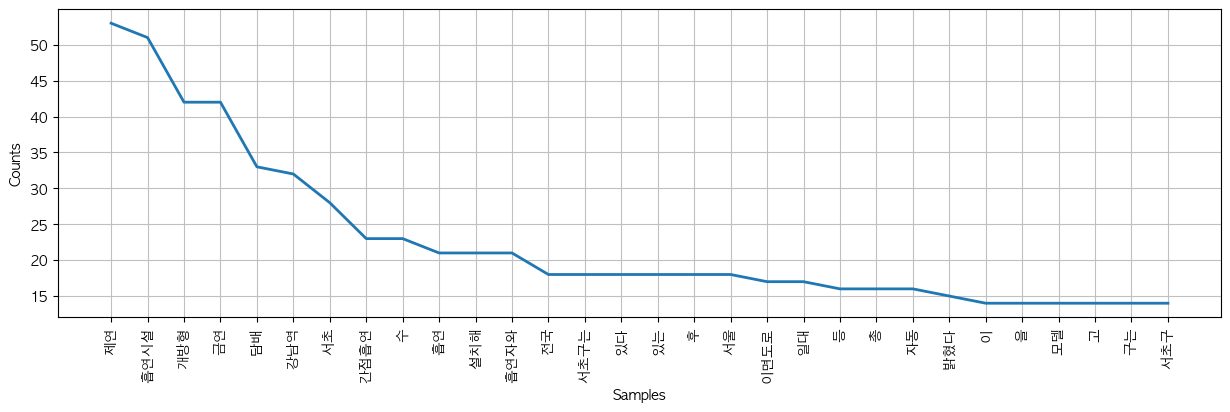

In [16]:
words = Text(words)
%matplotlib inline
rc('font', family='AppleGothic')
plt.rcParams['axes.unicode_minus'] = False
plt.figure(figsize=(15, 4))
words.plot(30)
plt.show()

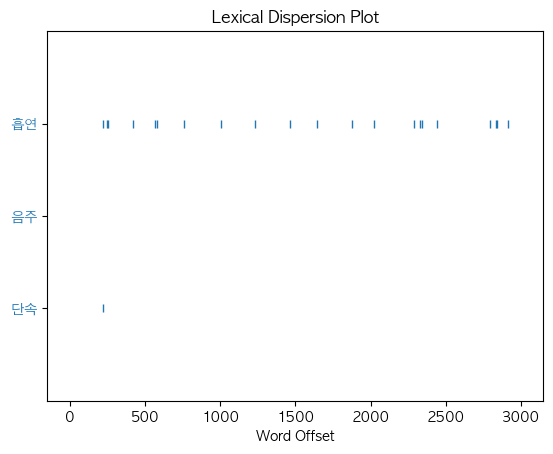

In [17]:
words.dispersion_plot(['흡연', '음주', '단속'])
plt.show()

# 한글 형태소 분석

In [18]:
text = ' '.join(words)

## Hannanum

In [19]:
hannanum = Hannanum(jvmpath=None, max_heap_size=1024)

In [20]:
hannanum.analyze(text)
# for word in words:
#     print(hannanum.analyze(word))

[[[('서초', 'ncn')], [('서초', 'nqq')]],
 [[('개방형', 'ncn')], [('개방', 'ncpa'), ('형', 'ncn')]],
 [[('제', 'xp'), ('연', 'ncn')]],
 [[('흡연', 'ncpa'), ('시설', 'ncpa')]],
 [[('출처', 'ncn')]],
 [[('연합', 'ncpa'), ('뉴스', 'ncn')]],
 [[('전국', 'ncn')], [('전', 'xp'), ('국', 'ncn')]],
 [[('최초', 'ncn'), ('로', 'jca')]],
 [[('개방형', 'ncn')], [('개방', 'ncpa'), ('형', 'ncn')]],
 [[('흡연', 'ncpa'), ('시설', 'ncpa')]],
 [[('이', 'mmd')], [('이', 'ncn')], [('이', 'nnc')], [('이', 'npd')]],
 [[('설치', 'ncpa'), ('되', 'xsvn'), ('었', 'ep'), ('다', 'ef')]],
 [[('개방형', 'ncn')], [('개방', 'ncpa'), ('형', 'ncn')]],
 [[('흡연', 'ncpa'), ('시설', 'ncpa'), ('은', 'jxc')],
  [('흡연', 'ncpa'), ('시설', 'ncpa'), ('은', 'ncn')]],
 [[('벽', 'ncn')]],
 [[('없이', 'mag')], [('없', 'paa'), ('이', 'xsam')]],
 [[('열', 'pvg'), ('리', 'ep'), ('ㄴ', 'etm')], [('열리', 'pvg'), ('ㄴ', 'etm')]],
 [[('형태', 'ncn'), ('로', 'jca')]],
 [[('에어', 'ncn'), ('커튼', 'ncn'), ('과', 'jcj')],
  [('에어', 'ncn'), ('커튼', 'ncn'), ('과', 'jct')],
  [('에어', 'ncn'), ('커튼', 'ncn'), ('과', 'ncn')]],
 [[

In [21]:
# 형태소 분석
hannanum.morphs(text)

['서초',
 '개방형',
 '제',
 '연',
 '흡연시설',
 '출처',
 '연합뉴스',
 '전국',
 '최초',
 '로',
 '개방형',
 '흡연시설',
 '이',
 '설치',
 '되',
 '었다',
 '개방형',
 '흡연시설',
 '은',
 '벽',
 '없이',
 '열리',
 'ㄴ',
 '형태',
 '로',
 '에어커튼',
 '과',
 '제',
 '연',
 '정화장치',
 '가',
 '설치',
 '되',
 'ㄴ',
 '시설',
 '이',
 '다',
 '서울시',
 '서초구',
 '는',
 '강남역',
 '이면도로',
 '서초대',
 '로',
 '길',
 'ㄹ',
 '일대',
 '에',
 '서초',
 '개방형',
 '제',
 '연',
 '흡연시설',
 '을',
 '운영',
 '하',
 'ㄴ다',
 '고',
 '일',
 '밝히',
 '었다',
 '서초구',
 '는',
 '다음',
 '달',
 '강남역',
 '인근',
 '곳',
 '에',
 '더',
 '설치',
 '하',
 'ㄹ',
 '예정',
 '이',
 '라',
 '고',
 '전하',
 '었다',
 '개방형',
 '흡연시설',
 '이',
 '설치',
 '되',
 'ㄴ',
 '강남역',
 '이면도로',
 '는',
 '음식점',
 '업무시설',
 '등',
 '상업시설',
 '이',
 '밀집',
 '하',
 '어',
 '유동',
 '인구',
 '가',
 '많',
 '다',
 '따르',
 '아서',
 '무분별한',
 '흡연',
 '이',
 '잇',
 '어',
 '지',
 '고',
 '있',
 '었다',
 '보행자',
 '의',
 '간접흡연',
 '피해',
 '를',
 '최소',
 '화하',
 '는',
 '것',
 '이',
 '개방형',
 '흡연시설',
 '설치',
 '의',
 '취지',
 '이',
 '다',
 '이',
 '시설',
 '은',
 '가로',
 '세',
 '로',
 '높이',
 '의',
 '규모',
 '이',
 '다',
 '기둥',
 '개',
 '로',
 '떠받치',
 '는',
 '구조',
 '로',

In [22]:
# 명사만 추출
hannanum.nouns(text)

['서초',
 '개방형',
 '연',
 '흡연시설',
 '출처',
 '연합뉴스',
 '전국',
 '최초',
 '개방형',
 '흡연시설',
 '설치',
 '개방형',
 '흡연시설',
 '벽',
 '형태',
 '에어커튼',
 '연',
 '정화장치',
 '설치',
 '시설',
 '서울시',
 '서초구',
 '강남역',
 '이면도로',
 '서초대',
 '일대',
 '서초',
 '개방형',
 '연',
 '흡연시설',
 '을',
 '운영',
 '일',
 '서초구',
 '다음',
 '달',
 '강남역',
 '인근',
 '곳',
 '설치',
 '예정',
 '개방형',
 '흡연시설',
 '설치',
 '강남역',
 '이면도로',
 '음식점',
 '업무시설',
 '등',
 '상업시설',
 '밀집',
 '유동',
 '인구',
 '무분별한',
 '흡연',
 '보행자',
 '간접흡연',
 '피해',
 '최소',
 '것',
 '개방형',
 '흡연시설',
 '설치',
 '취지',
 '시설',
 '세',
 '의',
 '규모',
 '기둥',
 '개',
 '구조',
 '최대',
 '명',
 '이용',
 '수',
 '시설',
 '벽면',
 '면',
 '지붕',
 '포함',
 '면',
 '중',
 '이상',
 '개방형',
 '것',
 '권고',
 '세계보건기구',
 '담배규제기본협약',
 '시설',
 '면',
 '에어커튼',
 '설치',
 '지붕',
 '회오리',
 '특허',
 '공법',
 '연',
 '정화장치',
 '대',
 '탑재',
 '개',
 '기둥',
 '각각',
 '자동',
 '소화',
 '기능',
 '재떨이',
 '개',
 '설치',
 '전성수',
 '서초구청장',
 '이번',
 '시설',
 '간접흡연',
 '최소화',
 '흡연자',
 '흡연자',
 '상생',
 '목표',
 '수년간',
 '고민',
 '끝',
 '모델',
 '이',
 '앞',
 '주민들',
 '체감할',
 '수',
 '간접흡연',
 '예방',
 '금연',
 '정책',
 '추진',
 '말',
 '일각',
 '흡연',
 

In [23]:
# 품사태그
hannanum.pos(text)

[('서초', 'N'),
 ('개방형', 'N'),
 ('제', 'X'),
 ('연', 'N'),
 ('흡연시설', 'N'),
 ('출처', 'N'),
 ('연합뉴스', 'N'),
 ('전국', 'N'),
 ('최초', 'N'),
 ('로', 'J'),
 ('개방형', 'N'),
 ('흡연시설', 'N'),
 ('이', 'M'),
 ('설치', 'N'),
 ('되', 'X'),
 ('었다', 'E'),
 ('개방형', 'N'),
 ('흡연시설', 'N'),
 ('은', 'J'),
 ('벽', 'N'),
 ('없이', 'M'),
 ('열리', 'P'),
 ('ㄴ', 'E'),
 ('형태', 'N'),
 ('로', 'J'),
 ('에어커튼', 'N'),
 ('과', 'J'),
 ('제', 'X'),
 ('연', 'N'),
 ('정화장치', 'N'),
 ('가', 'J'),
 ('설치', 'N'),
 ('되', 'X'),
 ('ㄴ', 'E'),
 ('시설', 'N'),
 ('이', 'J'),
 ('다', 'E'),
 ('서울시', 'N'),
 ('서초구', 'N'),
 ('는', 'J'),
 ('강남역', 'N'),
 ('이면도로', 'N'),
 ('서초대', 'N'),
 ('로', 'J'),
 ('길', 'P'),
 ('ㄹ', 'E'),
 ('일대', 'N'),
 ('에', 'J'),
 ('서초', 'N'),
 ('개방형', 'N'),
 ('제', 'X'),
 ('연', 'N'),
 ('흡연시설', 'N'),
 ('을', 'N'),
 ('운영', 'N'),
 ('하', 'X'),
 ('ㄴ다', 'E'),
 ('고', 'J'),
 ('일', 'N'),
 ('밝히', 'P'),
 ('었다', 'E'),
 ('서초구', 'N'),
 ('는', 'J'),
 ('다음', 'N'),
 ('달', 'N'),
 ('강남역', 'N'),
 ('인근', 'N'),
 ('곳', 'N'),
 ('에', 'J'),
 ('더', 'M'),
 ('설치', 'N'),
 ('하', 'X'),


In [24]:
hannanum.pos(text, ntags=22)

[('서초', 'NC'),
 ('개방형', 'NC'),
 ('제', 'XP'),
 ('연', 'NC'),
 ('흡연시설', 'NC'),
 ('출처', 'NC'),
 ('연합뉴스', 'NC'),
 ('전국', 'NC'),
 ('최초', 'NC'),
 ('로', 'JC'),
 ('개방형', 'NC'),
 ('흡연시설', 'NC'),
 ('이', 'MM'),
 ('설치', 'NC'),
 ('되', 'XS'),
 ('었', 'EP'),
 ('다', 'EF'),
 ('개방형', 'NC'),
 ('흡연시설', 'NC'),
 ('은', 'JX'),
 ('벽', 'NC'),
 ('없이', 'MA'),
 ('열리', 'PV'),
 ('ㄴ', 'ET'),
 ('형태', 'NC'),
 ('로', 'JC'),
 ('에어커튼', 'NC'),
 ('과', 'JC'),
 ('제', 'XP'),
 ('연', 'NC'),
 ('정화장치', 'NC'),
 ('가', 'JC'),
 ('설치', 'NC'),
 ('되', 'XS'),
 ('ㄴ', 'ET'),
 ('시설', 'NC'),
 ('이', 'JP'),
 ('다', 'EF'),
 ('서울시', 'NC'),
 ('서초구', 'NC'),
 ('는', 'JX'),
 ('강남역', 'NC'),
 ('이면도로', 'NC'),
 ('서초대', 'NC'),
 ('로', 'JC'),
 ('길', 'PA'),
 ('ㄹ', 'ET'),
 ('일', 'NN'),
 ('대', 'NB'),
 ('에', 'JC'),
 ('서초', 'NC'),
 ('개방형', 'NC'),
 ('제', 'XP'),
 ('연', 'NC'),
 ('흡연시설', 'NC'),
 ('을', 'NC'),
 ('운영', 'NC'),
 ('하', 'XS'),
 ('ㄴ다', 'EF'),
 ('고', 'JC'),
 ('일', 'NN'),
 ('밝히', 'PV'),
 ('었', 'EP'),
 ('다', 'EF'),
 ('서초구', 'NC'),
 ('는', 'JX'),
 ('다음', 'NC'),
 ('달'

In [25]:
# 보통명사(NC)만 추출
hannanum_tagged_text = hannanum.pos(text, ntags=22)
[word for word, tag in hannanum_tagged_text if tag == 'NC']

['서초',
 '개방형',
 '연',
 '흡연시설',
 '출처',
 '연합뉴스',
 '전국',
 '최초',
 '개방형',
 '흡연시설',
 '설치',
 '개방형',
 '흡연시설',
 '벽',
 '형태',
 '에어커튼',
 '연',
 '정화장치',
 '설치',
 '시설',
 '서울시',
 '서초구',
 '강남역',
 '이면도로',
 '서초대',
 '서초',
 '개방형',
 '연',
 '흡연시설',
 '을',
 '운영',
 '서초구',
 '다음',
 '강남역',
 '인근',
 '설치',
 '예정',
 '개방형',
 '흡연시설',
 '설치',
 '강남역',
 '이면도로',
 '음식점',
 '업무시설',
 '상업시설',
 '밀집',
 '유동',
 '인구',
 '무분별한',
 '흡연',
 '보행자',
 '간접흡연',
 '피해',
 '최소',
 '개방형',
 '흡연시설',
 '설치',
 '취지',
 '시설',
 '의',
 '규모',
 '기둥',
 '최대',
 '이용',
 '시설',
 '벽면',
 '면',
 '지붕',
 '포함',
 '이상',
 '개방형',
 '권고',
 '세계보건기구',
 '담배규제기본협약',
 '시설',
 '면',
 '에어커튼',
 '설치',
 '지붕',
 '회오리',
 '특허',
 '공법',
 '연',
 '정화장치',
 '탑재',
 '기둥',
 '각각',
 '자동',
 '소화',
 '기능',
 '재떨이',
 '설치',
 '전성수',
 '서초구청장',
 '시설',
 '간접흡연',
 '최소화',
 '흡연자',
 '흡연자',
 '상생',
 '목표',
 '수년간',
 '고민',
 '끝',
 '모델',
 '앞',
 '주민들',
 '체감할',
 '간접흡연',
 '예방',
 '금연',
 '정책',
 '추진',
 '말',
 '일각',
 '흡연',
 '자제하자',
 '세계적',
 '추세',
 '감안',
 '시민',
 '세금',
 '흡연',
 '편의',
 '도모',
 '지적',
 '금연클리닉',
 '사업',
 '눈길전문',
 '상담사가',
 '금연',
 '지원',
 '

## Kkma

In [26]:
kkma = Kkma()

In [27]:
# 형태소 분석
kkma.morphs(text)

['서초',
 '개방형',
 '저',
 '의',
 '연',
 '흡연',
 '시설',
 '출처',
 '연합',
 '뉴스',
 '전국',
 '최초',
 '로',
 '개방형',
 '흡연',
 '시설',
 '이',
 '설치',
 '되',
 '었',
 '다',
 '개방형',
 '흡연',
 '시설',
 '은',
 '벽',
 '없이',
 '열리',
 'ㄴ',
 '형태',
 '로',
 '에어',
 '커튼',
 '과',
 '저',
 '의',
 '연',
 '정화',
 '장치',
 '가',
 '설치',
 '되',
 'ㄴ',
 '시설',
 '이',
 '다',
 '서울시',
 '서초구',
 '는',
 '강남',
 '역',
 '이면',
 '도로',
 '서초',
 '대로',
 '길',
 '일대',
 '에',
 '서초',
 '개방형',
 '저',
 '의',
 '연',
 '흡연',
 '시설',
 '을',
 '운영',
 '하',
 'ㄴ다고',
 '일',
 '밝히',
 '었',
 '다',
 '서초구',
 '는',
 '다음',
 '달',
 '강남',
 '역',
 '인근',
 '곳',
 '에',
 '더',
 '설치',
 '하',
 'ㄹ',
 '예정',
 '이',
 '라고',
 '전하',
 '었',
 '다',
 '개방형',
 '흡연',
 '시설',
 '이',
 '설치',
 '되',
 'ㄴ',
 '강남',
 '역',
 '이면',
 '도로',
 '는',
 '음식점',
 '업무',
 '시설',
 '등',
 '상업',
 '시설',
 '이',
 '밀집',
 '하',
 '어',
 '유동',
 '인구',
 '가',
 '많',
 '다',
 '따라서',
 '무분별',
 '하',
 'ㄴ',
 '흡연',
 '이',
 '이어지',
 '고',
 '있',
 '었',
 '다',
 '보행자',
 '의',
 '간접',
 '흡연',
 '피해',
 '를',
 '최소화',
 '하',
 '는',
 '것',
 '이',
 '개방형',
 '흡연',
 '시설',
 '설치',
 '의',
 '취지',
 '다',
 '이',
 '시설',
 '은',


In [28]:
# 명사만 추출
kkma.nouns(text)

['서초',
 '개방형',
 '저',
 '연',
 '흡연',
 '흡연시설',
 '시설',
 '출처',
 '연합',
 '연합뉴스',
 '뉴스',
 '전국',
 '최초',
 '이',
 '설치',
 '벽',
 '형태',
 '에어',
 '에어커튼',
 '커튼',
 '정화',
 '정화장치',
 '장치',
 '서울시',
 '서초',
 '서초구',
 '구',
 '강남',
 '강남역',
 '역',
 '이면',
 '이면도로',
 '도로',
 '길',
 '일대',
 '을',
 '운영',
 '일',
 '다음',
 '달',
 '인근',
 '곳',
 '예정',
 '음식점',
 '업무',
 '업무시설',
 '등',
 '상업',
 '상업시설',
 '밀집',
 '유동',
 '인구',
 '무분별',
 '보행자',
 '간접',
 '간접흡연',
 '피해',
 '최소화',
 '취지',
 '가로',
 '세로',
 '높이',
 '의',
 '규모',
 '기둥',
 '개로',
 '구조',
 '최대',
 '명이',
 '동시',
 '이용',
 '수',
 '벽면',
 '면',
 '지붕',
 '포함',
 '중',
 '이상',
 '권고',
 '세계',
 '세계보건기구',
 '보건',
 '기구',
 '담배',
 '담배규제기본협약',
 '규제',
 '기본',
 '협약',
 '회오리',
 '특허',
 '공법',
 '제',
 '제연',
 '대가',
 '탑재',
 '개',
 '각각',
 '자동',
 '소화',
 '기능',
 '재떨이',
 '개가',
 '전성',
 '전성수',
 '수',
 '서초구청장',
 '청장',
 '이번',
 '흡연자',
 '간',
 '상생',
 '목표',
 '수년',
 '수년간',
 '고민',
 '끝',
 '모델',
 '앞',
 '주민',
 '체감',
 '예방',
 '금연',
 '정책',
 '추진',
 '고',
 '일각',
 '자제',
 '세계적',
 '추세',
 '감안',
 '때',
 '시민',
 '세금',
 '편의',
 '도모',
 '지적',
 '금연클리닉',
 '클리닉',
 '사업',
 '눈길

In [29]:
# 품사태그
kkma.pos(text)

[('서초', 'NNG'),
 ('개방형', 'NNG'),
 ('저', 'NP'),
 ('의', 'JKG'),
 ('연', 'NNG'),
 ('흡연', 'NNG'),
 ('시설', 'NNG'),
 ('출처', 'NNG'),
 ('연합', 'NNG'),
 ('뉴스', 'NNG'),
 ('전국', 'NNG'),
 ('최초', 'NNG'),
 ('로', 'JKM'),
 ('개방형', 'NNG'),
 ('흡연', 'NNG'),
 ('시설', 'NNG'),
 ('이', 'NNG'),
 ('설치', 'NNG'),
 ('되', 'XSV'),
 ('었', 'EPT'),
 ('다', 'ECS'),
 ('개방형', 'NNG'),
 ('흡연', 'NNG'),
 ('시설', 'NNG'),
 ('은', 'JX'),
 ('벽', 'NNG'),
 ('없이', 'MAG'),
 ('열리', 'VV'),
 ('ㄴ', 'ETD'),
 ('형태', 'NNG'),
 ('로', 'JKM'),
 ('에어', 'NNG'),
 ('커튼', 'NNG'),
 ('과', 'JKM'),
 ('저', 'NP'),
 ('의', 'JKG'),
 ('연', 'NNG'),
 ('정화', 'NNG'),
 ('장치', 'NNG'),
 ('가', 'JKS'),
 ('설치', 'NNG'),
 ('되', 'XSV'),
 ('ㄴ', 'ETD'),
 ('시설', 'NNG'),
 ('이', 'VCP'),
 ('다', 'ECS'),
 ('서울시', 'NNG'),
 ('서초구', 'NNP'),
 ('는', 'JX'),
 ('강남', 'NNG'),
 ('역', 'NNG'),
 ('이면', 'NNG'),
 ('도로', 'NNG'),
 ('서초', 'NNG'),
 ('대로', 'JX'),
 ('길', 'NNG'),
 ('일대', 'NNG'),
 ('에', 'JKM'),
 ('서초', 'NNG'),
 ('개방형', 'NNG'),
 ('저', 'NP'),
 ('의', 'JKG'),
 ('연', 'NNG'),
 ('흡연', 'NNG'),
 ('시설

In [30]:
# 보통명사(NNG), 고유명사(NNP)만 추출
kkma_tagged_text = kkma.pos(text)
[word for word, tag in kkma_tagged_text if (tag == 'NNG') + (tag == 'NNP')]

['서초',
 '개방형',
 '연',
 '흡연',
 '시설',
 '출처',
 '연합',
 '뉴스',
 '전국',
 '최초',
 '개방형',
 '흡연',
 '시설',
 '이',
 '설치',
 '개방형',
 '흡연',
 '시설',
 '벽',
 '형태',
 '에어',
 '커튼',
 '연',
 '정화',
 '장치',
 '설치',
 '시설',
 '서울시',
 '서초구',
 '강남',
 '역',
 '이면',
 '도로',
 '서초',
 '길',
 '일대',
 '서초',
 '개방형',
 '연',
 '흡연',
 '시설',
 '을',
 '운영',
 '일',
 '서초구',
 '다음',
 '달',
 '강남',
 '역',
 '인근',
 '곳',
 '설치',
 '예정',
 '개방형',
 '흡연',
 '시설',
 '설치',
 '강남',
 '역',
 '이면',
 '도로',
 '음식점',
 '업무',
 '시설',
 '상업',
 '시설',
 '밀집',
 '유동',
 '인구',
 '무분별',
 '흡연',
 '보행자',
 '간접',
 '흡연',
 '피해',
 '최소화',
 '개방형',
 '흡연',
 '시설',
 '설치',
 '취지',
 '시설',
 '가로',
 '세로',
 '높이',
 '의',
 '규모',
 '기둥',
 '개로',
 '구조',
 '최대',
 '명이',
 '동시',
 '이용',
 '시설',
 '벽면',
 '면',
 '지붕',
 '포함',
 '면',
 '이상',
 '개방형',
 '권고',
 '세계',
 '보건',
 '기구',
 '담배',
 '규제',
 '기본',
 '협약',
 '시설',
 '면',
 '에어',
 '커튼',
 '설치',
 '지붕',
 '회오리',
 '특허',
 '공법',
 '제',
 '연',
 '정화',
 '장치',
 '대가',
 '탑재',
 '개',
 '기둥',
 '각각',
 '자동',
 '소화',
 '기능',
 '재떨이',
 '개가',
 '설치',
 '전성',
 '수',
 '서초구',
 '청장',
 '이번',
 '시설',
 '간접',
 '흡연',
 '최소화',
 '

## Komoran

In [31]:
komoran = Komoran()

In [32]:
# 형태소 분석
komoran.morphs(text)

['서초',
 '개방',
 '형',
 '제',
 '연',
 '흡연',
 '시설',
 '출처',
 '연합뉴스',
 '전국',
 '최초',
 '로',
 '개방',
 '형',
 '흡연',
 '시설',
 '이',
 '설치',
 '되',
 '었',
 '다',
 '개방',
 '형',
 '흡연',
 '시설',
 '은',
 '벽',
 '없이',
 '열리',
 'ㄴ',
 '형태',
 '로',
 '에어',
 '커튼',
 '과',
 '제',
 '연',
 '정화',
 '장치',
 '가',
 '설치',
 '되',
 'ㄴ',
 '시설',
 '이',
 '다',
 '서울시',
 '서초구',
 '는',
 '강남역',
 '이',
 '면도',
 '로',
 '서초대로',
 '길',
 '일대',
 '에',
 '서초',
 '개방',
 '형',
 '제',
 '연',
 '흡연',
 '시설',
 '을',
 '운영',
 '하',
 'ㄴ다고',
 '일',
 '밝히',
 '었',
 '다',
 '서초구',
 '는',
 '다음',
 '달',
 '강남역',
 '인근',
 '곳',
 '에',
 '더',
 '설치',
 '하',
 'ㄹ',
 '예정',
 '이',
 '라고',
 '전하',
 '았',
 '다',
 '개방',
 '형',
 '흡연',
 '시설',
 '이',
 '설치',
 '되',
 'ㄴ',
 '강남역',
 '이',
 '면도',
 '로',
 '는',
 '음식점',
 '업무',
 '시설',
 '등',
 '상업시설',
 '이',
 '밀집',
 '하',
 '아',
 '유동',
 '인구',
 '가',
 '많',
 '다',
 '따라서',
 '무',
 '분별',
 '하',
 'ㄴ',
 '흡연',
 '이',
 '이어지',
 '고',
 '있',
 '었',
 '다',
 '보행자',
 '의',
 '간접흡연',
 '피해',
 '를',
 '최소',
 '화',
 '하',
 '는',
 '게',
 '개방',
 '형',
 '흡연',
 '시설',
 '설치',
 '의',
 '취지',
 '다',
 '이',
 '시설',
 '은',
 '가로',
 '

In [33]:
# 명사만 추출
komoran.nouns(text)

['서초',
 '개방',
 '연',
 '흡연',
 '시설',
 '출처',
 '연합뉴스',
 '전국',
 '최초',
 '개방',
 '흡연',
 '시설',
 '설치',
 '개방',
 '흡연',
 '시설',
 '벽',
 '형태',
 '에어',
 '커튼',
 '연',
 '정화',
 '장치',
 '설치',
 '시설',
 '서울시',
 '서초구',
 '강남역',
 '면도',
 '서초대로',
 '길',
 '일대',
 '서초',
 '개방',
 '연',
 '흡연',
 '시설',
 '을',
 '운영',
 '일',
 '서초구',
 '다음',
 '달',
 '강남역',
 '인근',
 '곳',
 '설치',
 '예정',
 '개방',
 '흡연',
 '시설',
 '설치',
 '강남역',
 '면도',
 '음식점',
 '업무',
 '시설',
 '등',
 '상업시설',
 '밀집',
 '유동',
 '인구',
 '분별',
 '흡연',
 '보행자',
 '간접흡연',
 '피해',
 '최소',
 '게',
 '개방',
 '흡연',
 '시설',
 '설치',
 '취지',
 '시설',
 '가로',
 '세로',
 '의',
 '규모',
 '기둥',
 '개',
 '구조',
 '최대',
 '명',
 '동시',
 '이용',
 '수',
 '시설',
 '벽면',
 '면',
 '지붕',
 '포함',
 '면',
 '중',
 '이상',
 '개방',
 '것',
 '권고',
 '세계보건기구',
 '담배',
 '규제',
 '기본',
 '협약',
 '시설',
 '면',
 '에어',
 '커튼',
 '설치',
 '지붕',
 '회오리',
 '특허',
 '공법',
 '연',
 '정화',
 '장치',
 '대',
 '탑재',
 '개',
 '기둥',
 '각각',
 '자동',
 '소화',
 '기능',
 '재떨이',
 '개',
 '설치',
 '성수',
 '서초',
 '구청장',
 '이번',
 '시설',
 '간접흡연',
 '최소',
 '흡연자',
 '흡연자',
 '간',
 '상생',
 '목표',
 '수',
 '년',
 '간',
 '고민',
 '끝',
 

In [34]:
# 품사태그
komoran.pos(text)

[('서초', 'NNP'),
 ('개방', 'NNG'),
 ('형', 'XSN'),
 ('제', 'XPN'),
 ('연', 'NNP'),
 ('흡연', 'NNP'),
 ('시설', 'NNG'),
 ('출처', 'NNG'),
 ('연합뉴스', 'NNP'),
 ('전국', 'NNG'),
 ('최초', 'NNG'),
 ('로', 'JKB'),
 ('개방', 'NNG'),
 ('형', 'XSN'),
 ('흡연', 'NNP'),
 ('시설', 'NNG'),
 ('이', 'MM'),
 ('설치', 'NNG'),
 ('되', 'XSV'),
 ('었', 'EP'),
 ('다', 'EC'),
 ('개방', 'NNG'),
 ('형', 'XSN'),
 ('흡연', 'NNP'),
 ('시설', 'NNG'),
 ('은', 'JX'),
 ('벽', 'NNG'),
 ('없이', 'MAG'),
 ('열리', 'VV'),
 ('ㄴ', 'ETM'),
 ('형태', 'NNG'),
 ('로', 'JKB'),
 ('에어', 'NNP'),
 ('커튼', 'NNP'),
 ('과', 'JC'),
 ('제', 'XPN'),
 ('연', 'NNP'),
 ('정화', 'NNP'),
 ('장치', 'NNP'),
 ('가', 'JKS'),
 ('설치', 'NNG'),
 ('되', 'XSV'),
 ('ㄴ', 'ETM'),
 ('시설', 'NNG'),
 ('이', 'VCP'),
 ('다', 'EC'),
 ('서울시', 'NNP'),
 ('서초구', 'NNP'),
 ('는', 'JX'),
 ('강남역', 'NNP'),
 ('이', 'MM'),
 ('면도', 'NNP'),
 ('로', 'JKB'),
 ('서초대로', 'NNP'),
 ('길', 'NNG'),
 ('일대', 'NNG'),
 ('에', 'JKB'),
 ('서초', 'NNP'),
 ('개방', 'NNG'),
 ('형', 'XSN'),
 ('제', 'XPN'),
 ('연', 'NNP'),
 ('흡연', 'NNP'),
 ('시설', 'NNG'),
 ('을', '

In [35]:
# 일반명사(NNG), 고유명사(NNP)만 추출
komoran_tagged_text = komoran.pos(text)
[word for word, tag in komoran_tagged_text if tag in ('NNG', 'NNP')]

['서초',
 '개방',
 '연',
 '흡연',
 '시설',
 '출처',
 '연합뉴스',
 '전국',
 '최초',
 '개방',
 '흡연',
 '시설',
 '설치',
 '개방',
 '흡연',
 '시설',
 '벽',
 '형태',
 '에어',
 '커튼',
 '연',
 '정화',
 '장치',
 '설치',
 '시설',
 '서울시',
 '서초구',
 '강남역',
 '면도',
 '서초대로',
 '길',
 '일대',
 '서초',
 '개방',
 '연',
 '흡연',
 '시설',
 '을',
 '운영',
 '서초구',
 '다음',
 '달',
 '강남역',
 '인근',
 '곳',
 '설치',
 '예정',
 '개방',
 '흡연',
 '시설',
 '설치',
 '강남역',
 '면도',
 '음식점',
 '업무',
 '시설',
 '상업시설',
 '밀집',
 '유동',
 '인구',
 '분별',
 '흡연',
 '보행자',
 '간접흡연',
 '피해',
 '최소',
 '게',
 '개방',
 '흡연',
 '시설',
 '설치',
 '취지',
 '시설',
 '가로',
 '세로',
 '의',
 '규모',
 '기둥',
 '구조',
 '최대',
 '동시',
 '이용',
 '시설',
 '벽면',
 '면',
 '지붕',
 '포함',
 '면',
 '이상',
 '개방',
 '권고',
 '세계보건기구',
 '담배',
 '규제',
 '기본',
 '협약',
 '시설',
 '면',
 '에어',
 '커튼',
 '설치',
 '지붕',
 '회오리',
 '특허',
 '공법',
 '연',
 '정화',
 '장치',
 '탑재',
 '기둥',
 '각각',
 '자동',
 '소화',
 '기능',
 '재떨이',
 '설치',
 '성수',
 '서초',
 '구청장',
 '이번',
 '시설',
 '간접흡연',
 '최소',
 '흡연자',
 '흡연자',
 '상생',
 '목표',
 '고민',
 '끝',
 '모델',
 '앞으로',
 '주민',
 '체감',
 '간접흡연',
 '예방',
 '금연',
 '정책',
 '추진',
 '말',
 '일각',
 '흡연',

## Twitter, Okt

In [36]:
twitter = Okt()

In [37]:
# 구 추출
twitter.phrases(text)

['서초',
 '서초 개방형',
 '서초 개방형 제연',
 '서초 개방형 제연 흡연시설',
 '서초 개방형 제연 흡연시설 출처',
 '서초 개방형 제연 흡연시설 출처 연합뉴스',
 '서초 개방형 제연 흡연시설 출처 연합뉴스 전국',
 '서초 개방형 제연 흡연시설 출처 연합뉴스 전국 최초',
 '개방형',
 '개방형 흡연시설',
 '개방형 흡연시설 이',
 '개방형 흡연시설 이 설치',
 '형태',
 '에어커튼',
 '에어커튼과 제연',
 '에어커튼과 제연 정화장치가',
 '에어커튼과 제연 정화장치가 설치',
 '에어커튼과 제연 정화장치가 설치된 시설',
 '서울시',
 '서울시 서초구',
 '강남역',
 '강남역 이면도로',
 '강남역 이면도로 서초대로',
 '강남역 이면도로 서초대로 길',
 '강남역 이면도로 서초대로 길 일대',
 '운영',
 '서초구',
 '다음',
 '다음 달',
 '다음 달 강남역',
 '다음 달 강남역 인근',
 '다음 달 강남역 인근 곳',
 '더 설치',
 '더 설치할 예정',
 '설치',
 '설치된 강남역',
 '설치된 강남역 이면도',
 '음식점',
 '음식점 업무시설',
 '음식점 업무시설 등',
 '음식점 업무시설 등 상업시설',
 '밀집',
 '유동',
 '유동 인구',
 '따라서',
 '따라서 무분별',
 '흡연',
 '보행자',
 '보행자의 간접흡연',
 '보행자의 간접흡연 피해',
 '최소',
 '최소화하는 게',
 '최소화하는 게 개방형',
 '최소화하는 게 개방형 흡연시설',
 '최소화하는 게 개방형 흡연시설 설치',
 '최소화하는 게 개방형 흡연시설 설치의 취지',
 '이 시설',
 '가로',
 '가로 세로',
 '가로 세로 높이',
 '가로 세로 높이 의',
 '가로 세로 높이 의 규모',
 '기둥',
 '기둥 개',
 '구조',
 '최대',
 '최대 명',
 '동시',
 '이용',
 '이용할 수',
 '벽면',
 '벽면 면',
 '벽면 면과 지붕',
 '포함',
 '총 면 중 이상',
 '권고',
 '권고하

In [38]:
# 형태소 분석
twitter.morphs(text)

['서초',
 '개방',
 '형',
 '제',
 '연',
 '흡연',
 '시설',
 '출처',
 '연합뉴스',
 '전국',
 '최초',
 '로',
 '개방',
 '형',
 '흡연',
 '시설',
 '이',
 '설치',
 '됐다',
 '개방',
 '형',
 '흡연',
 '시설',
 '은',
 '벽',
 '없이',
 '열린',
 '형태',
 '로',
 '에어',
 '커튼',
 '과',
 '제',
 '연',
 '정화',
 '장',
 '치가',
 '설치',
 '된',
 '시설',
 '이다',
 '서울시',
 '서초구',
 '는',
 '강남역',
 '이면',
 '도로',
 '서초대로',
 '길',
 '일대',
 '에',
 '서초',
 '개방',
 '형',
 '제',
 '연',
 '흡연',
 '시설',
 '을',
 '운영',
 '한다고',
 '일',
 '밝혔다',
 '서초구',
 '는',
 '다음',
 '달',
 '강남역',
 '인근',
 '곳',
 '에',
 '더',
 '설치',
 '할',
 '예정',
 '이라고',
 '전',
 '했다',
 '개방',
 '형',
 '흡연',
 '시설',
 '이',
 '설치',
 '된',
 '강남역',
 '이',
 '면도',
 '로는',
 '음식점',
 '업무',
 '시설',
 '등',
 '상업시설',
 '이',
 '밀집',
 '해',
 '유동',
 '인구',
 '가',
 '많다',
 '따라서',
 '무분별',
 '한',
 '흡연',
 '이',
 '이어지고',
 '있었다',
 '보행자',
 '의',
 '간접흡연',
 '피해',
 '를',
 '최소',
 '화하는',
 '게',
 '개방',
 '형',
 '흡연',
 '시설',
 '설치',
 '의',
 '취지',
 '다',
 '이',
 '시설',
 '은',
 '가로',
 '세로',
 '높이',
 '의',
 '규모',
 '다',
 '기둥',
 '개',
 '로',
 '떠받치는',
 '구조',
 '로',
 '최대',
 '명',
 '이',
 '동시',
 '에',
 '이용',
 '할',
 '수',
 '

In [39]:
# 명사만 추출
twitter.nouns(text)

['서초',
 '개방',
 '연',
 '흡연',
 '시설',
 '출처',
 '연합뉴스',
 '전국',
 '최초',
 '개방',
 '흡연',
 '시설',
 '이',
 '설치',
 '개방',
 '흡연',
 '시설',
 '벽',
 '형태',
 '에어',
 '커튼',
 '연',
 '정화',
 '치가',
 '설치',
 '시설',
 '서울시',
 '서초구',
 '강남역',
 '이면',
 '도로',
 '서초대로',
 '길',
 '일대',
 '서초',
 '개방',
 '연',
 '흡연',
 '시설',
 '운영',
 '일',
 '서초구',
 '다음',
 '달',
 '강남역',
 '인근',
 '곳',
 '더',
 '설치',
 '예정',
 '전',
 '개방',
 '흡연',
 '시설',
 '설치',
 '강남역',
 '면도',
 '음식점',
 '업무',
 '시설',
 '등',
 '상업시설',
 '밀집',
 '유동',
 '인구',
 '따라서',
 '무분별',
 '흡연',
 '보행자',
 '간접흡연',
 '피해',
 '최소',
 '게',
 '개방',
 '흡연',
 '시설',
 '설치',
 '취지',
 '이',
 '시설',
 '가로',
 '세로',
 '높이',
 '의',
 '규모',
 '기둥',
 '개',
 '구조',
 '최대',
 '명',
 '동시',
 '이용',
 '수',
 '이',
 '시설',
 '벽면',
 '면',
 '지붕',
 '포함',
 '총',
 '면',
 '중',
 '이상',
 '개방',
 '것',
 '권고',
 '세계보건기구',
 '담배',
 '규제',
 '협약',
 '이',
 '시설',
 '면',
 '에어',
 '커튼',
 '설치',
 '지붕',
 '회',
 '오리',
 '특허',
 '공법',
 '연',
 '정화',
 '장치',
 '대가',
 '탑재',
 '또',
 '개',
 '기둥',
 '각각',
 '자동',
 '소화',
 '기능',
 '재떨이',
 '개',
 '설치',
 '전성수',
 '서초구청장',
 '이번',
 '시설',
 '간접흡연',
 '최소',
 '흡연',
 

In [40]:
# 품사태그
twitter.pos(text)

[('서초', 'Noun'),
 ('개방', 'Noun'),
 ('형', 'Suffix'),
 ('제', 'Modifier'),
 ('연', 'Noun'),
 ('흡연', 'Noun'),
 ('시설', 'Noun'),
 ('출처', 'Noun'),
 ('연합뉴스', 'Noun'),
 ('전국', 'Noun'),
 ('최초', 'Noun'),
 ('로', 'Josa'),
 ('개방', 'Noun'),
 ('형', 'Suffix'),
 ('흡연', 'Noun'),
 ('시설', 'Noun'),
 ('이', 'Noun'),
 ('설치', 'Noun'),
 ('됐다', 'Verb'),
 ('개방', 'Noun'),
 ('형', 'Suffix'),
 ('흡연', 'Noun'),
 ('시설', 'Noun'),
 ('은', 'Josa'),
 ('벽', 'Noun'),
 ('없이', 'Adverb'),
 ('열린', 'Verb'),
 ('형태', 'Noun'),
 ('로', 'Josa'),
 ('에어', 'Noun'),
 ('커튼', 'Noun'),
 ('과', 'Josa'),
 ('제', 'Modifier'),
 ('연', 'Noun'),
 ('정화', 'Noun'),
 ('장', 'Suffix'),
 ('치가', 'Noun'),
 ('설치', 'Noun'),
 ('된', 'Verb'),
 ('시설', 'Noun'),
 ('이다', 'Josa'),
 ('서울시', 'Noun'),
 ('서초구', 'Noun'),
 ('는', 'Josa'),
 ('강남역', 'Noun'),
 ('이면', 'Noun'),
 ('도로', 'Noun'),
 ('서초대로', 'Noun'),
 ('길', 'Noun'),
 ('일대', 'Noun'),
 ('에', 'Josa'),
 ('서초', 'Noun'),
 ('개방', 'Noun'),
 ('형', 'Suffix'),
 ('제', 'Modifier'),
 ('연', 'Noun'),
 ('흡연', 'Noun'),
 ('시설', 'Noun'),
 ('을

In [41]:
twitter_tagged_text = twitter.pos(text)
[word for word, tag in twitter_tagged_text if tag == 'Noun']

['서초',
 '개방',
 '연',
 '흡연',
 '시설',
 '출처',
 '연합뉴스',
 '전국',
 '최초',
 '개방',
 '흡연',
 '시설',
 '이',
 '설치',
 '개방',
 '흡연',
 '시설',
 '벽',
 '형태',
 '에어',
 '커튼',
 '연',
 '정화',
 '치가',
 '설치',
 '시설',
 '서울시',
 '서초구',
 '강남역',
 '이면',
 '도로',
 '서초대로',
 '길',
 '일대',
 '서초',
 '개방',
 '연',
 '흡연',
 '시설',
 '운영',
 '일',
 '서초구',
 '다음',
 '달',
 '강남역',
 '인근',
 '곳',
 '더',
 '설치',
 '예정',
 '전',
 '개방',
 '흡연',
 '시설',
 '설치',
 '강남역',
 '면도',
 '음식점',
 '업무',
 '시설',
 '등',
 '상업시설',
 '밀집',
 '유동',
 '인구',
 '따라서',
 '무분별',
 '흡연',
 '보행자',
 '간접흡연',
 '피해',
 '최소',
 '게',
 '개방',
 '흡연',
 '시설',
 '설치',
 '취지',
 '이',
 '시설',
 '가로',
 '세로',
 '높이',
 '의',
 '규모',
 '기둥',
 '개',
 '구조',
 '최대',
 '명',
 '동시',
 '이용',
 '수',
 '이',
 '시설',
 '벽면',
 '면',
 '지붕',
 '포함',
 '총',
 '면',
 '중',
 '이상',
 '개방',
 '것',
 '권고',
 '세계보건기구',
 '담배',
 '규제',
 '협약',
 '이',
 '시설',
 '면',
 '에어',
 '커튼',
 '설치',
 '지붕',
 '회',
 '오리',
 '특허',
 '공법',
 '연',
 '정화',
 '장치',
 '대가',
 '탑재',
 '또',
 '개',
 '기둥',
 '각각',
 '자동',
 '소화',
 '기능',
 '재떨이',
 '개',
 '설치',
 '전성수',
 '서초구청장',
 '이번',
 '시설',
 '간접흡연',
 '최소',
 '흡연',
 

# 워드 클라우드

In [42]:
fontpath = '/System/Library/Fonts/Supplemental/AppleGothic.ttf'

In [43]:
word_list = [word for word, tag in kkma_tagged_text if tag in ('NNG', 'NNP')]
data_noun = ' '.join(word_list)

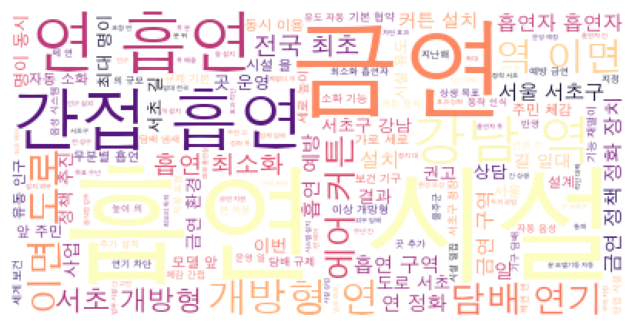

In [44]:
wordc = WordCloud(
            background_color='white',
            max_words=400,
            relative_scaling=0.3,
            colormap='magma',
            font_path=fontpath
)
# word = ' '.join(text)
wordc.generate(data_noun)
plt.figure(figsize=(10, 4))
plt.imshow(wordc)
plt.axis('off')
plt.show()

In [45]:
import nltk
import matplotlib.pyplot as plt
from konlpy.corpus import kolaw

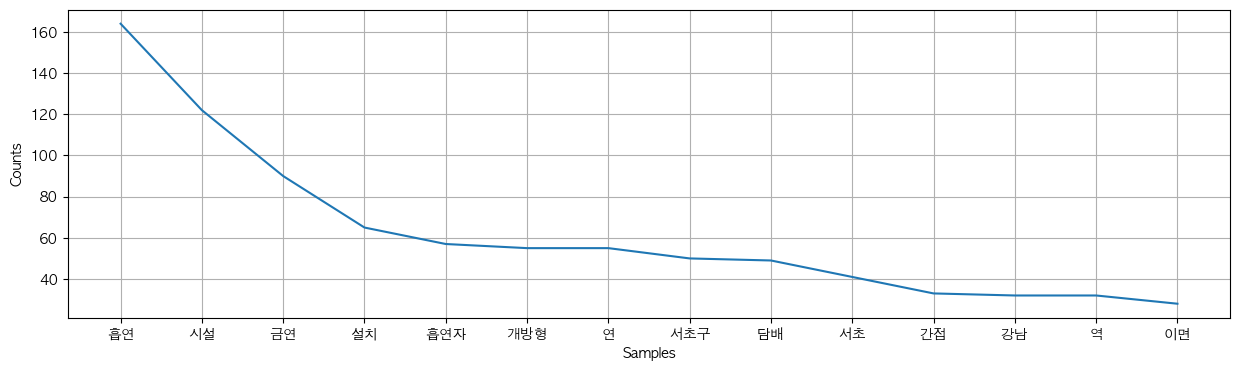

In [46]:
word_list = [word for word, tag in kkma_tagged_text if tag in ('NNG', 'NNP')]
data_text = nltk.Text(word_list)
words, counts = zip(*data_text.vocab().most_common(14))
plt.figure(figsize=(15, 4))
plt.plot(words, counts)
plt.xticks(rotation=0)
plt.xlabel('Samples')
plt.ylabel('Counts')
plt.grid()
plt.show()

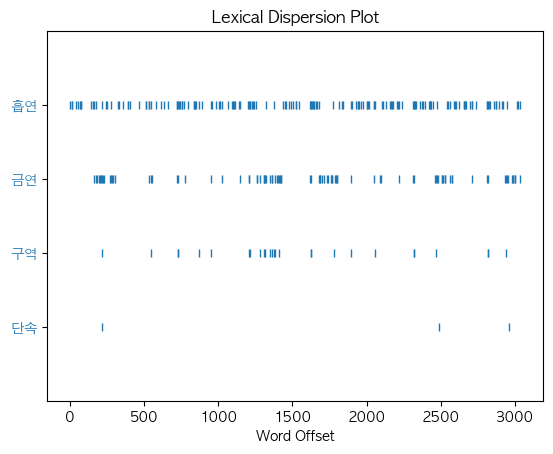

In [47]:
data_text.dispersion_plot(['흡연', '금연', '구역', '단속'])
plt.show()

# RNN

## 전처리

In [48]:
t = Tokenizer()
t.fit_on_texts([word_list])
encoded = t.texts_to_sequences([word_list])[0]
print(encoded)
print(t.word_index)

[10, 6, 7, 1, 2, 323, 207, 174, 24, 35, 6, 1, 2, 246, 4, 6, 1, 2, 247, 208, 25, 20, 7, 29, 54, 4, 2, 324, 8, 12, 13, 14, 15, 10, 60, 33, 10, 6, 7, 1, 2, 42, 17, 30, 8, 175, 176, 12, 13, 47, 21, 4, 86, 6, 1, 2, 4, 12, 13, 14, 15, 129, 130, 2, 111, 2, 112, 87, 88, 89, 1, 325, 11, 1, 248, 22, 6, 1, 2, 4, 326, 2, 90, 91, 92, 50, 93, 37, 150, 113, 51, 69, 61, 70, 2, 94, 28, 34, 71, 28, 62, 6, 72, 63, 64, 95, 9, 96, 97, 98, 2, 28, 25, 20, 4, 34, 131, 132, 133, 99, 7, 29, 54, 327, 100, 65, 37, 328, 19, 73, 74, 55, 329, 4, 114, 115, 8, 101, 48, 2, 11, 1, 22, 5, 5, 36, 56, 75, 116, 36, 102, 117, 38, 57, 58, 76, 11, 1, 43, 3, 44, 45, 118, 330, 1, 331, 332, 333, 334, 249, 335, 336, 1, 337, 338, 339, 3, 177, 66, 250, 151, 77, 251, 3, 52, 66, 209, 77, 210, 67, 210, 119, 340, 341, 152, 78, 342, 52, 3, 153, 343, 211, 71, 252, 3, 66, 344, 250, 24, 35, 3, 153, 345, 346, 347, 211, 3, 18, 1, 212, 253, 348, 349, 3, 153, 350, 36, 51, 351, 211, 352, 3, 52, 66, 353, 354, 355, 151, 77, 251, 209, 356, 357, 77,

In [49]:
print(t.texts_to_sequences(['흡연', '금연']))
print(t.texts_to_sequences(['흡연', '금연'])[0])

[[1], [3]]
[1]


In [50]:
print(t.texts_to_matrix(['흡연', '금연']))
print(t.texts_to_matrix(['흡연', '금연'])[0])

[[0. 1. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.


In [51]:
for word, value in t.word_index.items():
    if value == 1:
        print('1 : ', word)
        break

1 :  흡연


In [52]:
key_to_find = '흡연'
values_with_key = [key for value, key in t.word_index.items() if value == key_to_find]

print(values_with_key)

[1]


In [53]:
# 한글만 남기고 나머지 문자(숫자, 특수문자 등)를 제거하는 함수
def remove_non_korean(sentence):
    return re.sub(r'[^가-힣\s]', '', sentence)

# 문장 리스트에서 한글만 남기고 필터링
filtered_sent_tokens = '.'.join([remove_non_korean(sentence) for sentence in sent_tokens])

# 결과 출력
print(filtered_sent_tokens)

In [54]:
sequences = []
for line in str(filtered_sent_tokens).split('.'):
    print('원본 문장 : ', line)
    encoded = t.texts_to_sequences([line])[0]
    print('encoded된 문장 : ', encoded)
    print()
    for i in range(0, len(encoded)-1):
        for j in range(i+2, len(encoded)+1):
            sequences.append(encoded[i : j])
print('sequences와 해석 : ')
for sequence in sequences:
    print('[', end='')
    for word_seq in sequence:
        for word, value in t.word_index.items():
            if word_seq == value:
                print('{} : {}'.format(word_seq, word), end=' ')
                break
    print(']')

원본 문장 :                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 

In [55]:
sequences

[[10, 6],
 [6, 247],
 [6, 247, 60],
 [6, 247, 60, 10],
 [6, 247, 60, 10, 6],
 [6, 247, 60, 10, 6, 30],
 [247, 60],
 [247, 60, 10],
 [247, 60, 10, 6],
 [247, 60, 10, 6, 30],
 [60, 10],
 [60, 10, 6],
 [60, 10, 6, 30],
 [10, 6],
 [10, 6, 30],
 [6, 30],
 [175, 176],
 [175, 176, 47],
 [175, 176, 47, 129],
 [175, 176, 47, 129, 285],
 [175, 176, 47, 129, 285, 87],
 [176, 47],
 [176, 47, 129],
 [176, 47, 129, 285],
 [176, 47, 129, 285, 87],
 [47, 129],
 [47, 129, 285],
 [47, 129, 285, 87],
 [129, 285],
 [129, 285, 87],
 [285, 87],
 [6, 90],
 [6, 90, 91],
 [6, 90, 91, 92],
 [6, 90, 91, 92, 50],
 [90, 91],
 [90, 91, 92],
 [90, 91, 92, 50],
 [91, 92],
 [91, 92, 50],
 [92, 50],
 [37, 150],
 [37, 150, 51],
 [37, 150, 51, 69],
 [37, 150, 51, 69, 115],
 [150, 51],
 [150, 51, 69],
 [150, 51, 69, 115],
 [51, 69],
 [51, 69, 115],
 [69, 115],
 [246, 94],
 [246, 94, 393],
 [246, 94, 393, 28],
 [94, 393],
 [94, 393, 28],
 [393, 28],
 [131, 132],
 [131, 132, 327],
 [132, 327],
 [65, 37],
 [65, 37, 19],
 [65

In [56]:
print([len(sequence) for sequence in sequences])

[2, 2, 3, 4, 5, 6, 2, 3, 4, 5, 2, 3, 4, 2, 3, 2, 2, 3, 4, 5, 6, 2, 3, 4, 5, 2, 3, 4, 2, 3, 2, 2, 3, 4, 5, 2, 3, 4, 2, 3, 2, 2, 3, 4, 5, 2, 3, 4, 2, 3, 2, 2, 3, 4, 2, 3, 2, 2, 3, 2, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 2, 3, 4, 5, 6, 7, 8, 9, 10, 2, 3, 4, 5, 6, 7, 8, 9, 2, 3, 4, 5, 6, 7, 8, 2, 3, 4, 5, 6, 7, 2, 3, 4, 5, 6, 2, 3, 4, 5, 2, 3, 4, 2, 3, 2, 2, 3, 4, 2, 3, 2, 2, 2, 3, 4, 5, 6, 7, 8, 9, 2, 3, 4, 5, 6, 7, 8, 2, 3, 4, 5, 6, 7, 2, 3, 4, 5, 6, 2, 3, 4, 5, 2, 3, 4, 2, 3, 2, 2, 3, 4, 5, 6, 7, 8, 9, 2, 3, 4, 5, 6, 7, 8, 2, 3, 4, 5, 6, 7, 2, 3, 4, 5, 6, 2, 3, 4, 5, 2, 3, 4, 2, 3, 2, 2, 3, 4, 5, 6, 7, 8, 2, 3, 4, 5, 6, 7, 2, 3, 4, 5, 6, 2, 3, 4, 5, 2, 3, 4, 2, 3, 2, 2, 3, 4, 5, 2, 3, 4, 2, 3, 2, 2, 3, 4, 5, 2, 3, 4, 2, 3, 2, 2, 3, 4, 5, 2, 3, 4, 2, 3, 2, 2, 3, 4, 5, 6, 7, 2, 3, 4, 5, 6, 2, 3, 4, 5, 2, 3, 4, 2, 3, 2, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 2, 3, 4, 5, 6, 7, 8, 

In [57]:
my_len = max([len(sequence) for sequence in sequences])
my_len

52

In [58]:
padded_sequence = pad_sequences(sequences=sequences,
                                maxlen=my_len,
                                padding='pre')
type(padded_sequence), padded_sequence.shape, padded_sequence

(numpy.ndarray,
 (5192, 52),
 array([[  0,   0,   0, ...,   0,  10,   6],
        [  0,   0,   0, ...,   0,   6, 247],
        [  0,   0,   0, ...,   6, 247,  60],
        ...,
        [  0,   0,   0, ...,   0, 102, 115],
        [  0,   0,   0, ..., 102, 115,   3],
        [  0,   0,   0, ...,   0, 115,   3]], dtype=int32))

In [59]:
X = padded_sequence[:, :-1]
y = padded_sequence[:, -1:]

In [60]:
vocab_size = len(t.word_index)
vocab_size

500

In [61]:
Y = to_categorical(y, vocab_size+1)
Y

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [62]:
X.shape, Y.shape

((5192, 51), (5192, 501))

## 모델 생성

In [66]:
model = Sequential()

model.add(Embedding(input_dim=vocab_size+1,
                    output_dim=vocab_size-1,
                    input_length=X.shape[1])
)
model.build((None, X.shape[1]))
model.add(SimpleRNN(units=64))
model.add(Dense(units=Y.shape[1], activation='softmax'))
print(model.summary())

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ (None, 51, 499)        │       249,999 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_1 (SimpleRNN)        │ (None, 64)             │        36,096 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 501)            │        32,565 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 318,660 (1.22 MB)

 Trainable params: 318,660 (1.22 MB)

 Non-trainable params: 0 (0.00 B)

None


## 학습과정 설정 및 학습하기

In [67]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
hist = model.fit(x=X, y=Y, epochs=100, verbose=2)

Epoch 1/100
163/163 - 2s - 11ms/step - accuracy: 0.1518 - loss: 4.5572
Epoch 2/100
163/163 - 1s - 9ms/step - accuracy: 0.5576 - loss: 2.5983
Epoch 3/100
163/163 - 1s - 9ms/step - accuracy: 0.7379 - loss: 1.4452
Epoch 4/100
163/163 - 1s - 9ms/step - accuracy: 0.8149 - loss: 0.9707
Epoch 5/100
163/163 - 1s - 9ms/step - accuracy: 0.8552 - loss: 0.7267
Epoch 6/100
163/163 - 1s - 9ms/step - accuracy: 0.8771 - loss: 0.5811
Epoch 7/100
163/163 - 1s - 9ms/step - accuracy: 0.8873 - loss: 0.4865
Epoch 8/100
163/163 - 1s - 9ms/step - accuracy: 0.8970 - loss: 0.4281
Epoch 9/100
163/163 - 1s - 9ms/step - accuracy: 0.9016 - loss: 0.3870
Epoch 10/100
163/163 - 1s - 9ms/step - accuracy: 0.9018 - loss: 0.3578
Epoch 11/100
163/163 - 1s - 9ms/step - accuracy: 0.9058 - loss: 0.3421
Epoch 12/100
163/163 - 1s - 9ms/step - accuracy: 0.9099 - loss: 0.3153
Epoch 13/100
163/163 - 1s - 9ms/step - accuracy: 0.9106 - loss: 0.2991
Epoch 14/100
163/163 - 1s - 9ms/step - accuracy: 0.9064 - loss: 0.2985
Epoch 15/100
1

In [68]:
hist.history.keys()

dict_keys(['accuracy', 'loss'])

In [69]:
loss, accuracy = model.evaluate(X, Y)
print(accuracy*100, '&')

163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9058 - loss: 0.2278
92.73883104324341 &


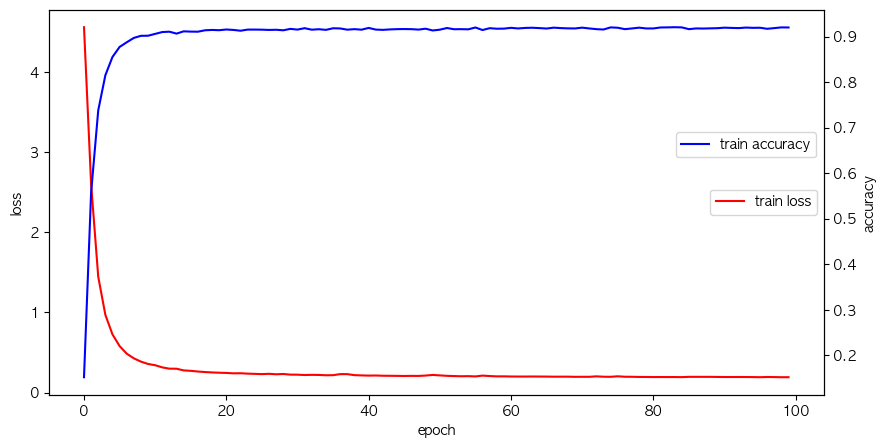

In [70]:
fig, loss_ax = plt.subplots(figsize=(10, 5))
loss_ax.plot(hist.history['loss'], 'r', label='train loss')
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax = loss_ax.twinx()
acc_ax.plot(hist.history['accuracy'], 'b', label='train accuracy')
acc_ax.set_ylabel('accuracy')
loss_ax.legend(loc='center right')
acc_ax.legend(bbox_to_anchor=(0.999, 0.7))
plt.show()